# Showcasing the interface between NEST and Elephant


![Elephant](images/nest_logo.png)

|||
|--:|---|
|Homepage|[https://www.nest-simulator.org/](https://www.nest-simulator.org/)  |
|GitHub|[https://github.com/nest/nest-simulator](https://github.com/nest/nest-simulator)|
|Documentation|[https://nest-simulator.readthedocs.io/en/latest/](https://nest-simulator.readthedocs.io/en/latest/)|
|Bug reports|[https://github.com/nest/nest-simulator/issues](https://github.com/nest/nest-simulator/issues) |
|conda|[https://anaconda.org/conda-forge/nest-simulator](https://anaconda.org/conda-forge/nest-simulator) |

# Example - NEST script that outputs spike data and is analyzed using Elephant 


* Simulating a Brunel model (random balanced network) with delta synapses, and outputting spike data to file.
* Calculate coefficient of variation and investigate spike train cross-correlations

In [1]:
%matplotlib inline


## 0. NEST: simulate random balanced network (delta synapses)

This script simulates an excitatory and an inhibitory population on
the basis of the network used in [1]_

This example of a random balanced network has been adapted from https://nest-simulator.readthedocs.io/en/v3.2/auto_examples/brunel_delta_nest.html.

When connecting the network, customary synapse models are used, which
allow for querying the number of created synapses. Using spike
recorders, the average firing rates of the neurons in the populations
are established.

### References

.. [1] Brunel N (2000). Dynamics of sparsely connected networks of excitatory and
       inhibitory spiking neurons. Journal of Computational Neuroscience 8,
       183-208.


Import all necessary modules 

In [2]:
import nest

nest.ResetKernel()


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: May 17 2023 20:48:31

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



Assigning the simulation parameters to variables.



In [3]:
dt = 0.1  # the resolution in ms
simtime = 1000.0  # Simulation time in ms /2000
delay = 1.5  # synaptic delay in ms

Definition of the parameters crucial for asynchronous irregular firing of
the neurons.



In [4]:
case="A"
g = 3  # ratio inhibitory weight/excitatory weight
eta = 2 # external rate relative to threshold rate

# case="B"
# g = 6  # ratio inhibitory weight/excitatory weight
# eta = 4 # external rate relative to threshold rate

# case="C"
# g = 5  # ratio inhibitory weight/excitatory weight
# eta = 2 # external rate relative to threshold rate

# case="D"
# g = 4.5  # ratio inhibitory weight/excitatory weight
# eta = 0.9 # external rate relative to threshold rate

epsilon = 0.1  # connection probability

Definition of the number of neurons in the network and the number of neurons
recorded from



In [5]:
order = 500 # originally 2500 /500
NE = 4 * order  # number of excitatory neurons
NI = 1 * order  # number of inhibitory neurons
N_neurons = NE + NI  # number of neurons in total
N_rec = 50  # record from 50 neurons

Definition of connectivity parameters



In [6]:
CE = int(epsilon * NE)  # number of excitatory synapses per neuron
CI = int(epsilon * NI)  # number of inhibitory synapses per neuron
C_tot = int(CI + CE)  # total number of synapses per neuron

Initialization of the parameters of the integrate and fire neuron and the
synapses. The parameters of the neuron are stored in a dictionary.



In [7]:
tauMem = 20.0  # time constant of membrane potential in ms
theta = 20.0  # membrane threshold potential in mV
neuron_params = {"C_m": 1.0,
                 "tau_m": tauMem,
                 "t_ref": 2.0,
                 "E_L": 0.0,
                 "V_reset": 0.0,
                 "V_m": 0.0,
                 "V_th": theta}
J = 0.1  # postsynaptic amplitude in mV
J_ex = J  # amplitude of excitatory postsynaptic potential
J_in = -g * J_ex  # amplitude of inhibitory postsynaptic potential

Definition of threshold rate, which is the external rate needed to fix the
membrane potential around its threshold, the external firing rate and the
rate of the poisson generator which is multiplied by the in-degree CE and
converted to Hz by multiplication by 1000.



In [8]:
nu_th = theta / (J * CE * tauMem)
nu_ex = eta * nu_th
p_rate = 1000.0 * nu_ex * CE

Configuration of the simulation kernel by the previously defined time
resolution used in the simulation. 



In [9]:
nest.resolution = dt
nest.overwrite_files = True

print("Building network")

Building network

Nov 24 09:51:30 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


Creation of the nodes using ``Create``. We store the returned handles in
variables for later reference. Here the excitatory and inhibitory, as well
as the poisson generator and two spike recorders. The spike recorders will
later be used to record excitatory and inhibitory spikes. Properties of the
nodes are specified via ``params``, which expects a dictionary.



In [10]:
nodes_ex = nest.Create("iaf_psc_delta", NE, params=neuron_params)
nodes_in = nest.Create("iaf_psc_delta", NI, params=neuron_params)
noise = nest.Create("poisson_generator", params={"rate": p_rate})
espikes = nest.Create("spike_recorder")
ispikes = nest.Create("spike_recorder")

Configuration of the spike recorders recording excitatory and inhibitory
spikes by sending parameter dictionaries to ``set``. Setting the property
`record_to` to *"ascii"* ensures that the spikes will be recorded to a file,
whose name starts with the string assigned to the property `label`.



In [11]:
espikes.set(label=f"{case}-brunel-py-ex", record_to="ascii", file_extension="gdf")
ispikes.set(label=f"{case}-brunel-py-in", record_to="ascii", file_extension="gdf")

print("Connecting devices")

Connecting devices


Definition of a synapse using ``CopyModel``, which expects the model name of
a pre-defined synapse, the name of the customary synapse and an optional
parameter dictionary. The parameters defined in the dictionary will be the
default parameter for the customary synapse. Here we define one synapse for
the excitatory and one for the inhibitory connections giving the
previously defined weights and equal delays.



In [12]:
nest.CopyModel("static_synapse", "excitatory",
               {"weight": J_ex, "delay": delay})
nest.CopyModel("static_synapse", "inhibitory",
               {"weight": J_in, "delay": delay})

Connecting the previously defined poisson generator to the excitatory and
inhibitory neurons using the excitatory synapse. Since the poisson
generator is connected to all neurons in the population the default rule
(# ``all_to_all``) of ``Connect`` is used. The synaptic properties are inserted
via ``syn_spec`` which expects a dictionary when defining multiple variables
or a string when simply using a pre-defined synapse.



In [13]:
nest.Connect(noise, nodes_ex, syn_spec="excitatory")
nest.Connect(noise, nodes_in, syn_spec="excitatory")

Connecting the first ``N_rec`` nodes of the excitatory and inhibitory
population to the associated spike recorders using excitatory synapses.
Here the same shortcut for the specification of the synapse as defined
above is used.



In [14]:
nest.Connect(nodes_ex[:N_rec], espikes, syn_spec="excitatory")
nest.Connect(nodes_in[:N_rec], ispikes, syn_spec="excitatory")

print("Connecting network")

print("Excitatory connections")

Connecting network
Excitatory connections


Connecting the excitatory population to all neurons using the pre-defined
excitatory synapse. Beforehand, the connection parameter are defined in a
dictionary. Here we use the connection rule ``fixed_indegree``,
which requires the definition of the indegree. Since the synapse
specification is reduced to assigning the pre-defined excitatory synapse it
suffices to insert a string.



In [15]:
conn_params_ex = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(nodes_ex, nodes_ex + nodes_in, conn_params_ex, "excitatory")

print("Inhibitory connections")

Inhibitory connections


Connecting the inhibitory population to all neurons using the pre-defined
inhibitory synapse. The connection parameters as well as the synapse
parameters are defined analogously to the connection from the excitatory
population defined above.



In [16]:
conn_params_in = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(nodes_in, nodes_ex + nodes_in, conn_params_in, "inhibitory")

Simulation of the network.



In [17]:
print("Simulating")

nest.Simulate(simtime)

Simulating

May 02 11:03:58 NodeManager::prepare_nodes [Info]: 
    Preparing 2503 nodes for simulation.

May 02 11:03:58 SimulationManager::run [Warning]: 
    The requested simulation time is not an integer multiple of the minimal 
    delay in the network. This may result in inconsistent results under the 
    following conditions: (i) A network contains more than one source of 
    randomness, e.g., two different poisson_generators, and (ii) Simulate is 
    called repeatedly with simulation times that are not multiples of the 
    minimal delay.

May 02 11:03:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2503
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

May 02 11:04:03 SimulationManager::run [Info]: 
    Simulation finished.


Storage of the time point after the simulation of the network in a variable.



## 1. Processing NEST data with Elephant
In the following we load the simulation data generated with NEST and perform anaysis with Elephant (Electrophysiology Analysis Toolkit).

---
### Hotfix: delete descriptive meta-data header prior to data

**with NEST 3.0 the following changes occured:** \
*In addition, most backends now write the name of the recorded variable for each column as a descriptive meta-data header prior to writing any data.\
see: (https://nest-simulator.readthedocs.io/en/v3.1/release_notes/v3.0/features/recording_simulations.html?highlight=meta-data)*

In order to use the `neo.io.nestio` the meta-data header for each column needs to be removed.

NestIO was developed with NEST 2.10.0, see `nestio.py`:\
*Class for reading output files from NEST simulations
( http://www.nest-simulator.org/ ).* \
**Tested with NEST 2.10.0** \
*Depends on: numpy, quantities* \
*Supported: Read* \
*Authors: Julia Sprenger, Maximilian Schmidt, Johanna Senk*

Until the IO for NEST in Neo is updated, the following hotfix is applied to the `.gdf`-files:\
(*once Neo is updated, simply remove* `'no_header_'`)

In [ ]:
## The follwoing lines remove the header from the .gdf files:
#
# gdf_files=[f'{case}-brunel-py-ex-12502-0.gdf',f'{case}-brunel-py-in-12503-0.gdf']
# prefix= f'{case}-no_header_'
# for file in gdf_files:
#     !tail -n +4 {file}>{prefix+file} # start at line 4 and save file.

---

### 1.1 Load simulation data 

In this example the data resulting from the NEST simulation, the `.gdf` files are loaded using the nestIO from **Neo** package.

```
# NEST version: 3.3
# RecordingBackendASCII version: 2
sender	time_ms
10	13.400
3	14.200
4	14.800
6	14.700
7	14.900
9	15.000
11	14.300
12	13.800
13	14.600
15	14.900
16	14.300
27	14.800
```

See also: https://neo.readthedocs.io/en/stable/io.html#neo.io.NestIO

In [19]:
from neo.io.nestio import NestIO
import quantities as pq

IO = NestIO('../data/simulation_data/A-no_header_A-brunel-py-ex-12502-0.gdf')
segment_A = IO.read_segment(
                     gid_list=[], # empty list to retrieve spiketrains from all neurons
                     t_start=0 * pq.ms,
                     t_stop=2000 * pq.ms,
                     id_column_gdf=0,  # column 0 contains the neuron ID
                     time_column_gdf=1, # column 1 contains the times in ms
                     )

In [20]:
IO = NestIO('../data/simulation_data/B-no_header_B-brunel-py-ex-12502-0.gdf')
segment_B = IO.read_segment(
                     gid_list=[], # empty list to retrieve spiketrains from all neurons
                     t_start=0 * pq.ms,
                     t_stop=2000 * pq.ms,
                     id_column_gdf=0,  # column 0 contains the neuron ID
                     time_column_gdf=1, # column 1 contains the times in ms
                     )
IO = NestIO('../data/simulation_data/C-no_header_C-brunel-py-ex-12502-0.gdf')
segment_C = IO.read_segment(
                     gid_list=[], # empty list to retrieve spiketrains from all neurons
                     t_start=0 * pq.ms,
                     t_stop=2000 * pq.ms,
                     id_column_gdf=0,  # column 0 contains the neuron ID
                     time_column_gdf=1, # column 1 contains the times in ms
                     )
IO = NestIO('../data/simulation_data/D-no_header_D-brunel-py-ex-12502-0.gdf')
segment_D = IO.read_segment(
                     gid_list=[], # empty list to retrieve spiketrains from all neurons
                     t_start=0 * pq.ms,
                     t_stop=2000 * pq.ms,
                     id_column_gdf=0,  # column 0 contains the neuron ID
                     time_column_gdf=1, # column 1 contains the times in ms
                     )

### 1.2 Visualize simulation data

The following example makes use of Viziphants `eventplot` function to get an overview of the simuation results.

See also: https://viziphant.readthedocs.io/en/latest/toctree/rasterplot/viziphant.rasterplot.eventplot.html#viziphant.rasterplot.eventplot

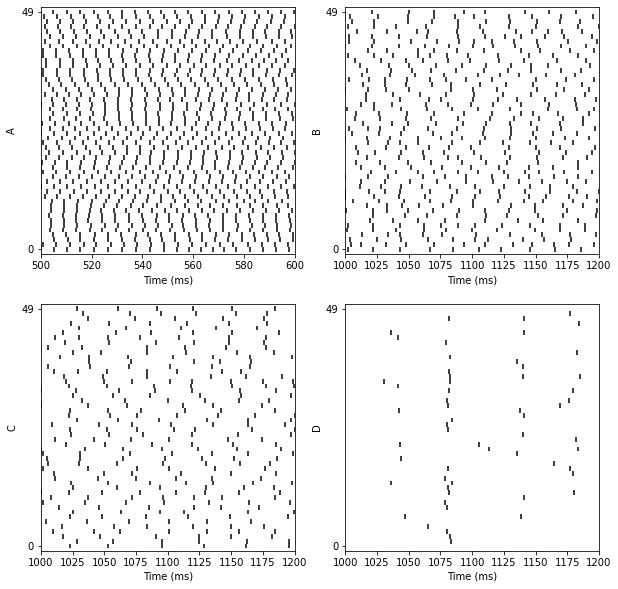

In [21]:
from viziphant.rasterplot import eventplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import gcf, gca

plt.subplot(2, 2, 1)
axes=eventplot(segment_A.spiketrains, linelengths=1, color='black', axes=gca())
axes.set_xlim(500,600)
axes.set_ylim(-1,50)
axes.set_ylabel('A')

plt.subplot(2, 2, 2)
axes=eventplot(segment_B.spiketrains, linelengths=1, color='black', axes=gca())
axes.set_xlim(1000,1200)
axes.set_ylim(-1,50)
axes.set_ylabel('B')

plt.subplot(2, 2, 3)
axes=eventplot(segment_C.spiketrains, linelengths=1, color='black', axes=gca())
axes.set_xlim(1000,1200)
axes.set_ylim(-1,50)
axes.set_ylabel('C')

plt.subplot(2, 2, 4)
axes=eventplot(segment_D.spiketrains, linelengths=1, color='black', axes=gca())
axes.set_xlim(1000,1200)
axes.set_ylim(-1,50)
axes.set_ylabel('D')

fig=gcf()
fig.set_size_inches(10,10)

The following descriptions for A, B, C, and D are taken from [1]: 

- A: Almost fully synchronized network, neurons firing regularly at high rates
- B: Fast oscillation of the global activity, neurons firing irregularly at a rate that is lower than the global frequency
- C: Stationary global activity, irregularly firing neurons
- D: Slow oscillation of the global activity, neurons firing irregularly at very low rates

How do those results compare to the results in source [1] ?


[1] Brunel N (2000). Dynamics of sparsely connected networks of excitatory and
       inhibitory spiking neurons. Journal of Computational Neuroscience 8,
       183-208.

### 1.3 Coefficient of Variation (CV)
In this section we will have a look at the coefficient of variation (CV), a measure of the variability of inter-spike intervals.
(spike train that is modeled as a random (stochastic) Poisson process has a CV of 1)

To calculate the distribution of the CVs obtained from inter-spike intervals (ISIs) of the simulated spike trains, we do the following:

- For each spike train, we first call elephants' `isi()` function which returns an array of all N-1 ISIs for the N spikes in the input spike train. 
- We then feed the list of ISIs into the `cv()` function, which returns a single value for the coefficient of variation.

See also:
- `isi()`: https://elephant.readthedocs.io/en/latest/reference/_toctree/statistics/elephant.statistics.isi.html#elephant.statistics.isi
- `cv()`: https://elephant.readthedocs.io/en/latest/reference/_toctree/statistics/elephant.statistics.cv.html#elephant.statistics.cv

In [22]:
from elephant.statistics import isi, cv
# calculate inter-spike intervals for the first spike train
print(isi(segment_A.spiketrains[0])[1:20]) 

[6.6 5.7 5.1 5.4 4.9 5.3 5.9 4.6 4.7 5.1 5.3 5.3 5.  5.  5.  5.2 5.2 5.
 5.1] ms


In [23]:
# calculate the the coefficients of variation for all spiketrains in case A
cv_list = [cv(isi(spiketrain)) for spiketrain in segment_A.spiketrains] 
print (cv_list[1:20])

[0.05365918694441147, 0.05842274732773983, 0.059250517400670354, 0.05214580130596291, 0.050847044837237135, 0.05060558092032044, 0.05330605601380723, 0.05658901823907235, 0.054583570070382184, 0.05684812500177874, 0.05088318480424918, 0.05672717009945042, 0.05713916820608826, 0.05790660466497289, 0.04834790725558421, 0.05273128217027347, 0.054580874407185814, 0.057038102986292194, 0.060156882820013316]


In the follwoing we create a histogram of the CVs for all cases (A, B, C and D).

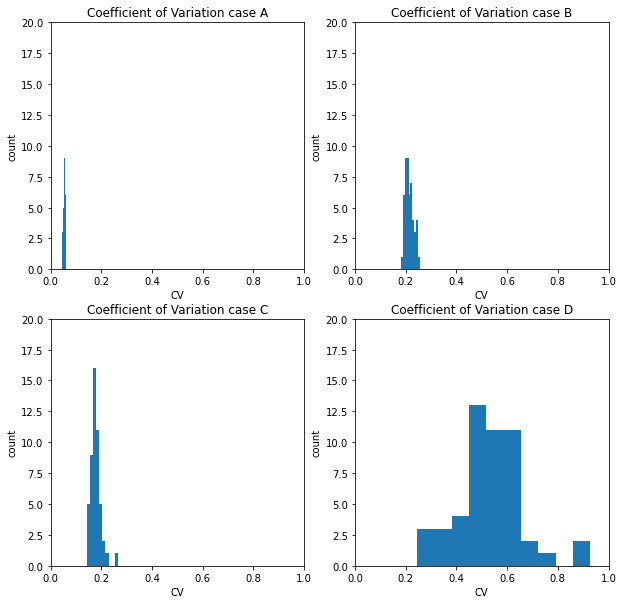

In [24]:
x_limits=(0,1)
y_limits=(0,20)

plt.subplot(2, 2, 1)
plt.hist(cv_list)
plt.xlim(x_limits)
plt.ylim(y_limits)
plt.xlabel('CV')
plt.ylabel('count')
plt.title("Coefficient of Variation case A")

plt.subplot(2, 2, 2)
plt.hist([cv(isi(spiketrain)) for spiketrain in segment_B.spiketrains])
plt.xlim(x_limits)
plt.ylim(y_limits)
plt.xlabel('CV')
plt.ylabel('count')
plt.title("Coefficient of Variation case B")

plt.subplot(2, 2, 3)
plt.hist([cv(isi(spiketrain)) for spiketrain in segment_C.spiketrains])
plt.xlim(x_limits)
plt.ylim(y_limits)
plt.xlabel('CV')
plt.ylabel('count')
plt.title("Coefficient of Variation case C")

plt.subplot(2, 2, 4)
plt.hist([cv(isi(spiketrain)) for spiketrain in segment_D.spiketrains])
plt.xlim(x_limits)
plt.ylim(y_limits)
plt.xlabel('CV')
plt.ylabel('count')
plt.title("Coefficient of Variation case D")

fig=gcf()
fig.set_size_inches(10,10)

### 1.4 Cross-correlation

Lets assess if there are correlations between the spike trains.

To investigate that, Elephant provides functions to calculate and plot the cross-correlation matrix. This matrix quantifies the similarity for each pair of spike trains in the trial. 

**Binning**

We start by binning the spike trains. Let's use a bin size of 3 ms. With this, we are obtaining the number of spikes that occurred during small intervals.

See also:
- BinnedSpikeTrain: https://elephant.readthedocs.io/en/latest/reference/_toctree/conversion/elephant.conversion.BinnedSpikeTrain.html#elephant.conversion.BinnedSpikeTrain

In [25]:
from elephant import conversion
binned_spiketrains_A = conversion.BinnedSpikeTrain(
                                                segment_A.spiketrains, 
                                                binsize=3*pq.ms
                                                )
print("Total number of bins: "+str(binned_spiketrains_A.n_bins))

Total number of bins: 666


/srv/main-spack-instance-2302/spack/var/spack/environments/ebrains-23-02/.spack-env/view/lib/python3.8/site-packages/elephant/conversion.py:1170: UserWarning:Binning discarded 23 last spike(s) of the input spiketrain


If we inspect the spike times of one neuron, we can see that if the neuron fired in a particular bin,
the `BinnedSpikeTrain` object will store the value 1.

In [26]:
print("Timepoints in ms where spike occured")
spiketrain_id=0
print(segment_A.spiketrains[spiketrain_id][0:8])
print("Timepoints in ms of bin edges")
print(binned_spiketrains_A[spiketrain_id].bin_edges[0:20])
print("Binned spiketrain")
print(binned_spiketrains_A[spiketrain_id].to_array()[0,0:20])

Timepoints in ms where spike occured
[13.9 18.1 24.7 30.4 35.5 40.9 45.8 51.1] ms
Timepoints in ms of bin edges
[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27. 30. 33. 36. 39. 42. 45. 48. 51.
 54. 57.] ms
Binned spiketrain
[0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1]


**cross-correlation matrix**

Then we calculate the cross-correlation matrix of the binned spikes using the `correlation_coefficient`
function from the `spike_train_correlation` module.

See also: https://elephant.readthedocs.io/en/latest/reference/_toctree/spike_train_correlation/elephant.spike_train_correlation.correlation_coefficient.html#elephant.spike_train_correlation.correlation_coefficient

In [27]:
from elephant import spike_train_correlation
cross_corr_matrix_A = spike_train_correlation.correlation_coefficient(binned_spiketrains_A)

Calculate the cross-correlation for the other cases.

In [28]:
# Case B
binned_spiketrains_B = conversion.BinnedSpikeTrain( # binning
                                                segment_B.spiketrains, 
                                                binsize=3*pq.ms
                                                )
cross_corr_matrix_B = spike_train_correlation.correlation_coefficient(binned_spiketrains_B) # calculate the cross-correlation matrix
# Case C
binned_spiketrains_C = conversion.BinnedSpikeTrain( # binning
                                                segment_C.spiketrains, 
                                                binsize=3*pq.ms
                                                )
cross_corr_matrix_C = spike_train_correlation.correlation_coefficient(binned_spiketrains_C) # calculate the cross-correlation matrix
# Case D
binned_spiketrains_D = conversion.BinnedSpikeTrain( # binning
                                                segment_D.spiketrains, 
                                                binsize=3*pq.ms
                                                )
cross_corr_matrix_D = spike_train_correlation.correlation_coefficient(binned_spiketrains_D) # calculate the cross-correlation matrix

/srv/main-spack-instance-2302/spack/var/spack/environments/ebrains-23-02/.spack-env/view/lib/python3.8/site-packages/elephant/conversion.py:1170: UserWarning:Binning discarded 1 last spike(s) of the input spiketrain
/srv/main-spack-instance-2302/spack/var/spack/environments/ebrains-23-02/.spack-env/view/lib/python3.8/site-packages/elephant/conversion.py:1170: UserWarning:Binning discarded 3 last spike(s) of the input spiketrain


### Viziphant
We visualize the matrix using the `plot_corrcoef` function of Viziphant. To compare the coefficients, we will set correlation_range to fixed values, to use the color bar only in the same range for all cases. We will also not plot the values along the main diagonal, as those are equal to 1, by setting remove_diagonal to True.

See also: https://viziphant.readthedocs.io/en/latest/toctree/spike_train_correlation/viziphant.spike_train_correlation.plot_corrcoef.html#viziphant.spike_train_correlation.plot_corrcoef

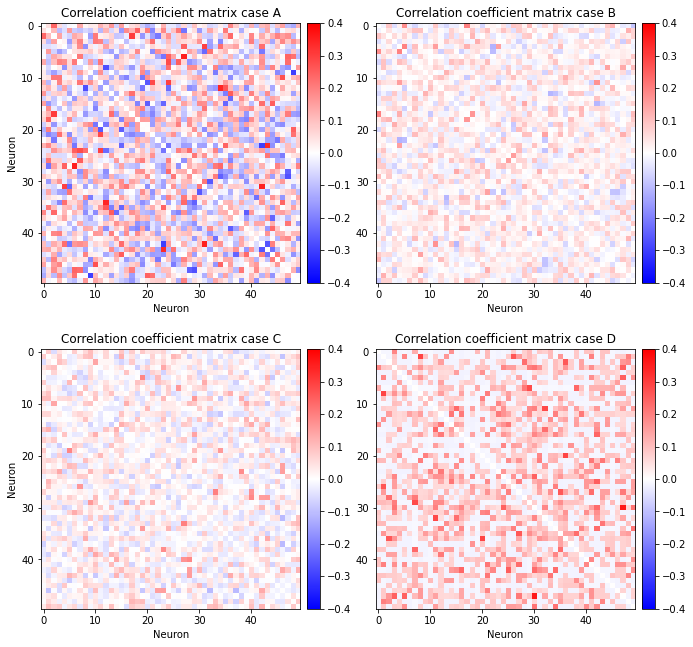

In [29]:
from viziphant.spike_train_correlation import plot_corrcoef
correlation_range=(-0.4,0.4)

plt.subplot(2, 2, 1)
axes=plot_corrcoef(cross_corr_matrix_A, axes=gca(), correlation_range=correlation_range,remove_diagonal=True)
axes.set_xlabel('Neuron')
axes.set_ylabel('Neuron')
axes.set_title("Correlation coefficient matrix case A");

plt.subplot(2, 2, 2)
axes=plot_corrcoef(cross_corr_matrix_B, axes=gca(), correlation_range=correlation_range,remove_diagonal=True)
axes.set_xlabel('Neuron')
axes.set_title("Correlation coefficient matrix case B");

plt.subplot(2, 2, 3)
axes=plot_corrcoef(cross_corr_matrix_C, axes=gca(), correlation_range=correlation_range,remove_diagonal=True)
axes.set_xlabel('Neuron')
axes.set_ylabel('Neuron')
axes.set_title("Correlation coefficient matrix case C");

plt.subplot(2, 2, 4)
axes=plot_corrcoef(cross_corr_matrix_D, axes=gca(), correlation_range=correlation_range,remove_diagonal=True)
axes.set_xlabel('Neuron')
axes.set_title("Correlation coefficient matrix case D");

fig=gcf()
fig.set_size_inches(11,11)

### 1.5 Spike train distance Victor-Purpura’s (VP) distance

Lets investigate the similarity of the spike trains.

To investigate that, Elephant provides different spike train similarity measures. In this case we will use the Victor-Purpura distance.

See also: https://elephant.readthedocs.io/en/latest/reference/_toctree/spike_train_dissimilarity/elephant.spike_train_dissimilarity.victor_purpura_distance.html

In [30]:
from elephant.spike_train_dissimilarity import victor_purpura_distance
pairwise_vp_distance_A = victor_purpura_distance(segment_A.spiketrains)

In [31]:
pairwise_vp_distance_B = victor_purpura_distance(segment_B.spiketrains)
pairwise_vp_distance_C = victor_purpura_distance(segment_C.spiketrains)
pairwise_vp_distance_D = victor_purpura_distance(segment_D.spiketrains)

Create plots with a colorbar for all cases.

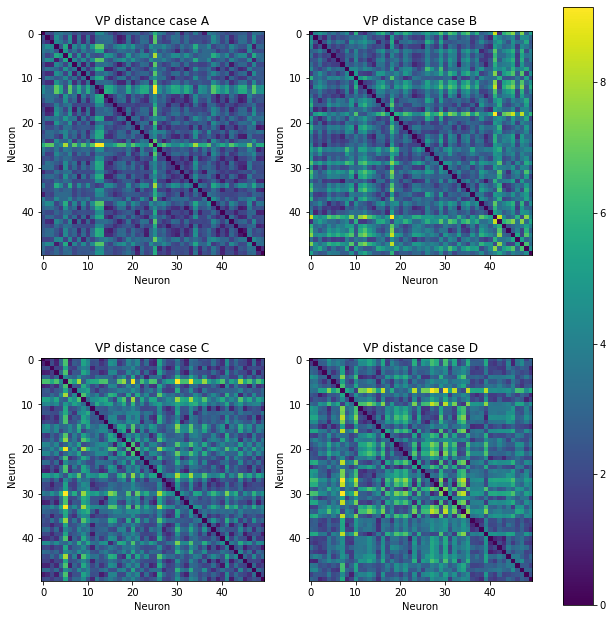

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2)
im=axes.flat[0].imshow(pairwise_vp_distance_A)
axes.flat[0].set_xlabel('Neuron')
axes.flat[0].set_ylabel('Neuron')
axes.flat[0].set_title("VP distance case A")

im=axes.flat[1].imshow(pairwise_vp_distance_B)
axes.flat[1].set_xlabel('Neuron')
axes.flat[1].set_ylabel('Neuron')
axes.flat[1].set_title("VP distance case B")

im=axes.flat[2].imshow(pairwise_vp_distance_C)
axes.flat[2].set_xlabel('Neuron')
axes.flat[2].set_ylabel('Neuron')
axes.flat[2].set_title("VP distance case C")

im=axes.flat[3].imshow(pairwise_vp_distance_D)
axes.flat[3].set_xlabel('Neuron')
axes.flat[3].set_ylabel('Neuron')
axes.flat[3].set_title("VP distance case D")

plt.colorbar(im, ax=axes.ravel().tolist()) # add colorbar

fig=gcf()
fig.set_size_inches(11,11)

In [33]:
# clear up working directory: remove simulation results
!rm -f A-brunel-py-ex-2502-0.gdf
!rm -f A-brunel-py-in-2503-0.gdf